In [1]:
# Data
import yfinance as yf
import yahooquery
import pandas_datareader as pdr
import pandas_market_calendars as mcal

# Maths
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Data handling
import numpy as np
import pandas as pd

# Utility
import datetime

# Just typical statistical arbitrage
# 1) Fit linear regression on ETF and component(s)
# 2) Portfolio = short ETF + long component

## Weight, leverage and margin
* Weight the captial allocation based on sharpe ratio ($w_i = \mathrm{sharpe}_i*\mathrm{Normalization}$)
* Leverage using $\mathrm{max}(\mathrm{sharpe}_i, 1.5)$ (US stock) for each pair
* include fee: transection, margin interest rate
* Open and close position at the first and last 15 mins in the data set respectively

In [4]:
def Get_top_10_ETF_symbols(ETF):
    holdings = yahooquery.Ticker(ETF).fund_holding_info[ETF]['holdings']
    return [holding['symbol'] for holding in holdings]
def Get_data(tickers, period="60d", interval="2m"):
    df = yf.download(tickers, period=period, interval=interval)['Close']
    df = df.dropna(axis=0, how='any')
    return df

In [19]:
# List of ETF: https://en.wikipedia.org/wiki/List_of_American_exchange-traded_funds 

#SMH_top_10_tickers = Get_top_10_ETF_symbols('SMH') # VanEck Semiconductor ETF    #####Seems work#####
#AMLP_top_10_tickers = Get_top_10_ETF_symbols('AMLP') # energy, ALPS Alerian MLP ETF   #####Seems work#####
#VDE_top_10_tickers = Get_top_10_ETF_symbols('VDE') # Vanguard Energy  
#XLF_top_10_tickers = Get_top_10_ETF_symbols('XLF') # Financial Select Sector SPDR
#VOO_top_10_tickers = Get_top_10_ETF_symbols('VOO') # Vanguard S&P 500 ETF

# Download data
ETF_ticker = 'VOO'
Tickers = Get_top_10_ETF_symbols(ETF_ticker)
Tickers.append(ETF_ticker)
df = Get_data(Tickers)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


In [20]:
df.head(5)

Ticker,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA,VOO
Datetime,,,,,,,,,,,
2025-03-03 14:30:00+00:00,241.684998,213.080002,201.190002,515.684998,174.565002,172.860001,678.890015,396.850006,122.710701,301.839996,548.599976
2025-03-03 14:32:00+00:00,243.250000,213.800003,199.580002,515.489990,174.565002,172.919998,679.270020,396.725494,122.934998,300.000092,548.650085
2025-03-03 14:34:00+00:00,243.610001,213.048401,197.889999,516.664978,174.024994,172.304993,675.844788,396.130005,121.790001,301.800110,548.385010
2025-03-03 14:36:00+00:00,243.399994,212.686996,196.529999,518.599976,173.600006,171.906906,674.659973,396.285004,121.230003,300.410004,548.222778
2025-03-03 14:38:00+00:00,242.880005,211.469894,195.411606,517.659973,172.990005,171.320007,671.328430,394.730011,120.632401,297.609985,547.429993


## Proof of concept

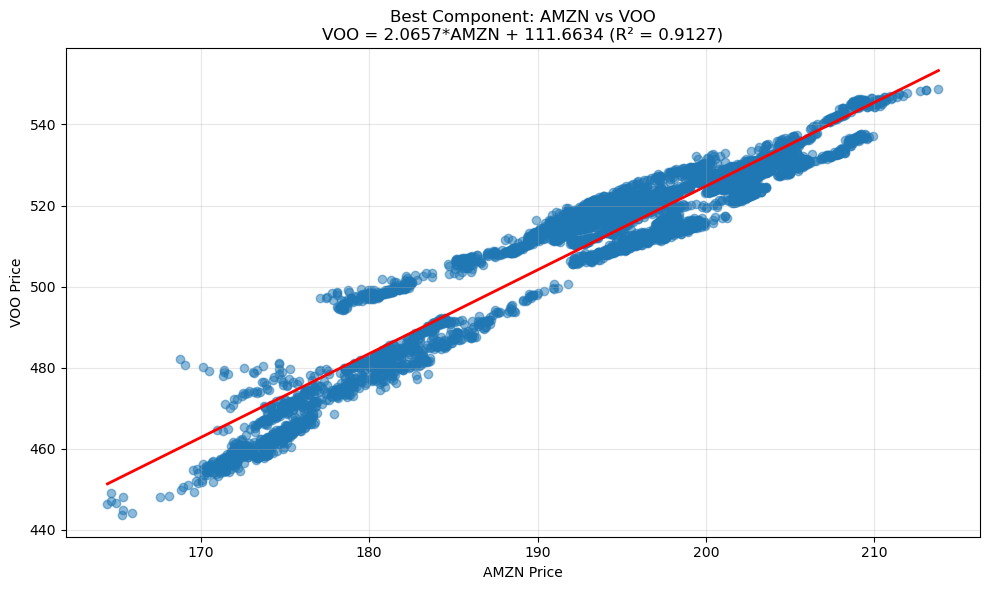

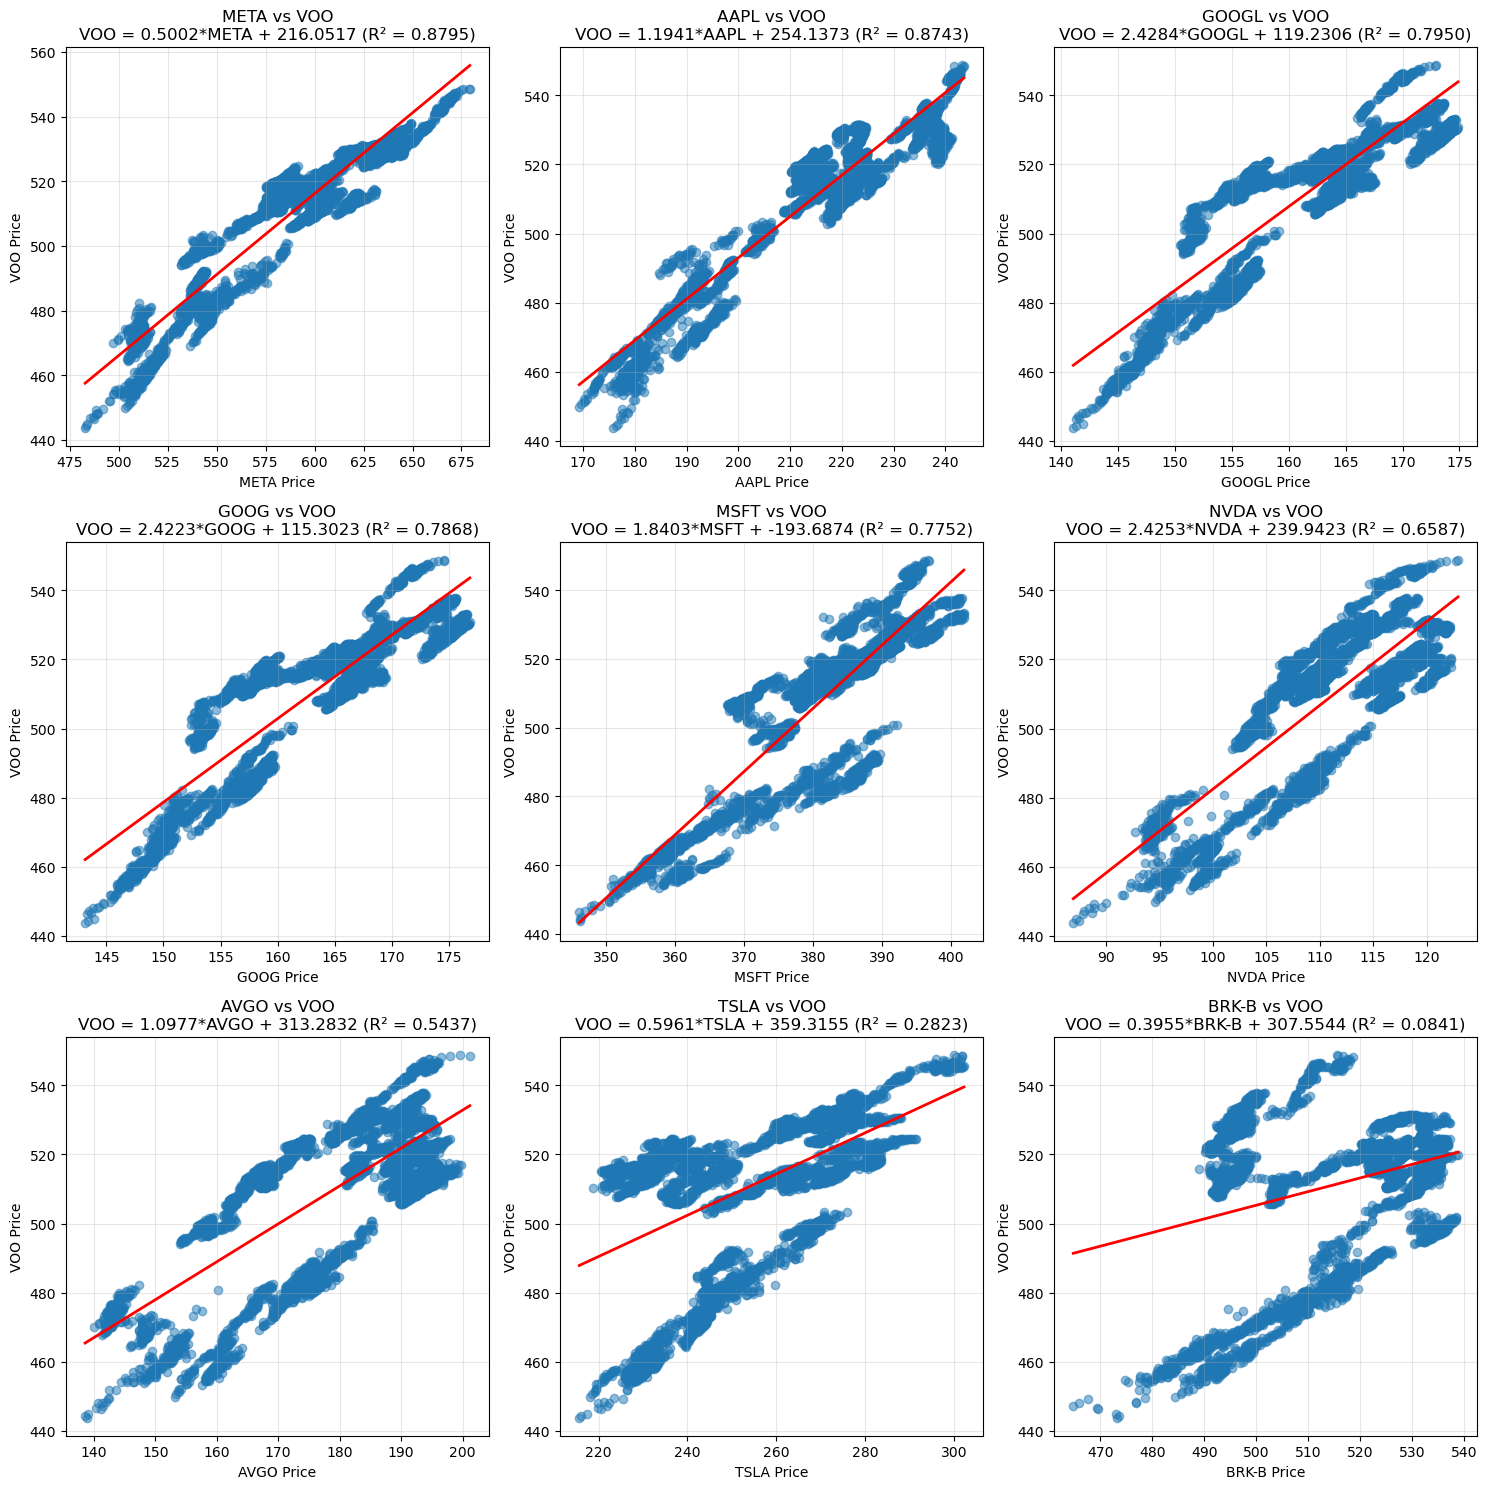

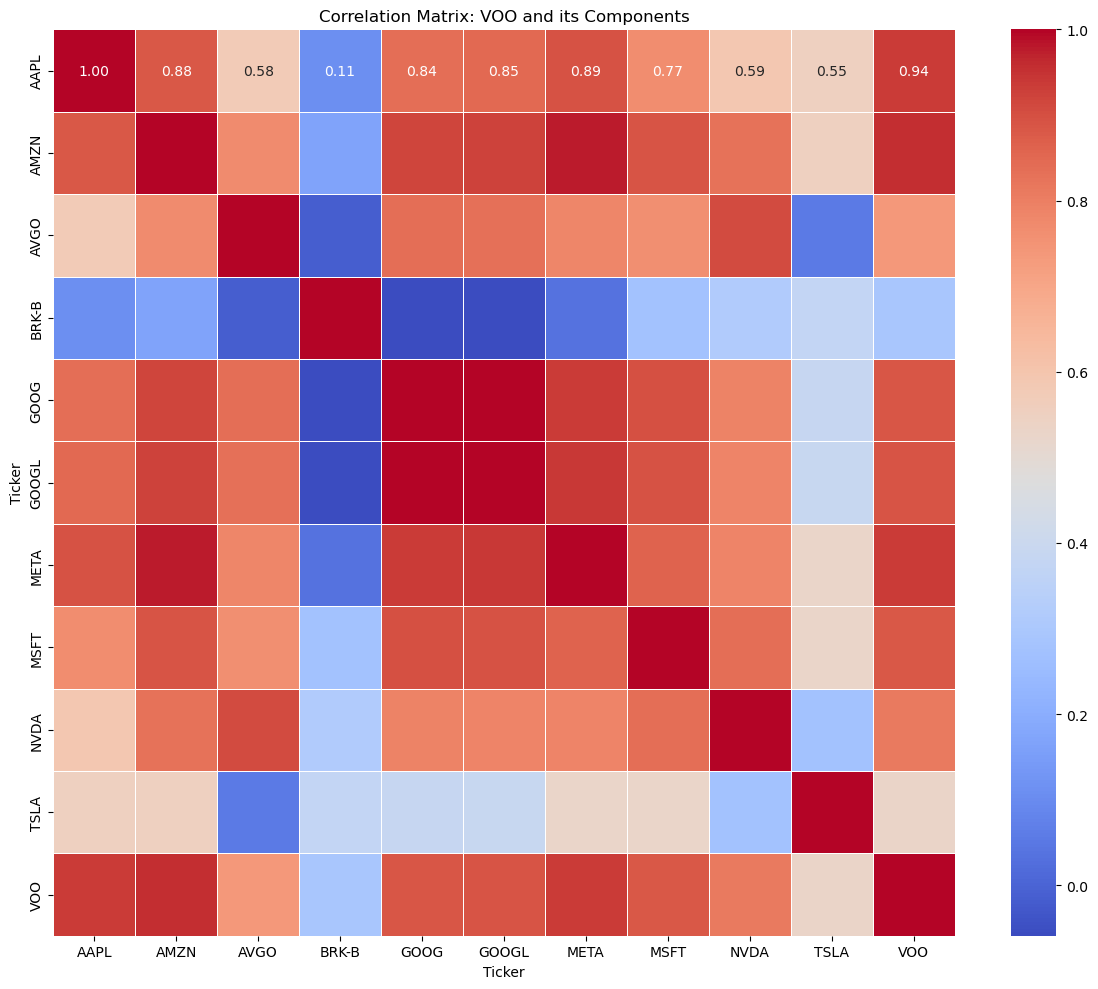

In [24]:
def analyze_etf_components(etf_ticker, df, plot_mode=False):
    etf_data = df[etf_ticker]
    component_data = df.drop(etf_ticker, axis=1)
    
    results_list = []
    for ticker in component_data.columns:
        component = component_data[ticker].dropna()
        etf = etf_data.loc[component.index]
        
        X = sm.add_constant(component)
        model = sm.OLS(etf, X).fit()
        
        results_list.append({
            'Ticker': ticker,
            'Beta': model.params.iloc[1],
            'Alpha': model.params.iloc[0],
            'R-squared': model.rsquared,
            'P-value': model.pvalues.iloc[1],
            'Std Error': model.bse.iloc[1]
        })
    
    regression_results = pd.DataFrame(results_list)
    regression_results = regression_results.sort_values('R-squared', ascending=False)
    
    top_component = regression_results.iloc[0]['Ticker']
    if plot_mode:
        plt.figure(figsize=(10, 6))
        x = component_data[top_component]
        y = etf_data
        plt.scatter(x, y, alpha=0.5)
        
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        
        x_pred = np.linspace(x.min(), x.max(), 100)
        x_pred2 = sm.add_constant(x_pred)
        y_pred = model.predict(x_pred2)
        
        plt.plot(x_pred, y_pred, 'r', linewidth=2)
        r_squared = regression_results[regression_results['Ticker'] == top_component]['R-squared'].values[0]
        beta = regression_results[regression_results['Ticker'] == top_component]['Beta'].values[0]
        alpha = regression_results[regression_results['Ticker'] == top_component]['Alpha'].values[0]
        
        plt.title(f'Best Component: {top_component} vs {etf_ticker}\n{etf_ticker} = {beta:.4f}*{top_component} + {alpha:.4f} (R² = {r_squared:.4f})')
        plt.xlabel(f'{top_component} Price')
        plt.ylabel(f'{etf_ticker} Price')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        remaining_components = regression_results.iloc[1:]['Ticker'].tolist()
        
        rows = 3
        cols = 3
        fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
        axs = axs.flatten()
        
        for i, ticker in enumerate(remaining_components):
            if i >= rows*cols:
                break
                
            x = component_data[ticker]
            y = etf_data
            
            axs[i].scatter(x, y, alpha=0.5)
            
            X = sm.add_constant(x)
            model = sm.OLS(y, X).fit()
            
            x_pred = np.linspace(x.min(), x.max(), 100)
            x_pred2 = sm.add_constant(x_pred)
            y_pred = model.predict(x_pred2)
            
            axs[i].plot(x_pred, y_pred, 'r', linewidth=2)
            r_squared = regression_results[regression_results['Ticker'] == ticker]['R-squared'].values[0]
            beta = regression_results[regression_results['Ticker'] == ticker]['Beta'].values[0]
            alpha = regression_results[regression_results['Ticker'] == ticker]['Alpha'].values[0]
            
            axs[i].set_title(f'{ticker} vs {etf_ticker}\n{etf_ticker} = {beta:.4f}*{ticker} + {alpha:.4f} (R² = {r_squared:.4f})')
            axs[i].set_xlabel(f'{ticker} Price')
            axs[i].set_ylabel(f'{etf_ticker} Price')
            axs[i].grid(True, alpha=0.3)
        
        for j in range(len(remaining_components), rows*cols):
            if j < len(axs):
                fig.delaxes(axs[j])
        
        plt.tight_layout()
        plt.show()
        
        correlation_matrix = df.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title(f'Correlation Matrix: {etf_ticker} and its Components')
        plt.tight_layout()
        plt.show()
    
    return regression_results

regression_results = analyze_etf_components(ETF_ticker, df, plot_mode=True)

In [25]:
print(regression_results)

  Ticker      Beta       Alpha  R-squared        P-value  Std Error
1   AMZN  2.065672  111.663441   0.912670   0.000000e+00   0.008356
6   META  0.500171  216.051710   0.879534   0.000000e+00   0.002421
0   AAPL  1.194147  254.137281   0.874305   0.000000e+00   0.005921
5  GOOGL  2.428425  119.230646   0.795003   0.000000e+00   0.016125
4   GOOG  2.422319  115.302325   0.786768   0.000000e+00   0.016490
7   MSFT  1.840302 -193.687410   0.775200   0.000000e+00   0.012959
8   NVDA  2.425277  239.942255   0.658700   0.000000e+00   0.022829
2   AVGO  1.097654  313.283200   0.543682   0.000000e+00   0.013150
9   TSLA  0.596123  359.315536   0.282342   0.000000e+00   0.012428
3  BRK-B  0.395453  307.554353   0.084079  1.066067e-113   0.017068


In [28]:
def build_etf_component_portfolio(etf_ticker, df, regression_results, plot_mode=True):
    etf_data = df[etf_ticker]
    etf_returns = etf_data.pct_change().dropna()
    
    portfolio_returns = pd.DataFrame(index=etf_returns.index)
    cumulative_returns = pd.DataFrame(index=etf_returns.index)
    
    for i, row in regression_results.iterrows():
        component_ticker = row['Ticker']
        beta = row['Beta']
        
        component_data = df[component_ticker]
        component_returns = component_data.pct_change().dropna()
        
        common_idx = etf_returns.index.intersection(component_returns.index)
        
        portfolio_return = etf_returns.loc[common_idx] - beta * component_returns.loc[common_idx]
        portfolio_returns[component_ticker] = portfolio_return
        
        cumulative_return = (1 + portfolio_return).cumprod() - 1
        cumulative_returns[component_ticker] = cumulative_return
    
    if plot_mode:
        plt.figure(figsize=(14, 7))
        cumulative_returns.plot(figsize=(14, 7))
        plt.title(f'Pairs Trading: Long {etf_ticker}, Short Components (Beta-Weighted)')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend(title='Component Ticker')
        plt.tight_layout()
        plt.show()
    
    metrics = pd.DataFrame(index=portfolio_returns.columns)
    
    if pd.api.types.is_datetime64_any_dtype(df.index):
        time_diffs = pd.Series(df.index).diff().dropna()
        if len(time_diffs) > 0:
            seconds_per_period = time_diffs.mean().total_seconds()
            seconds_per_year = 365 * 24 * 60 * 60
            periods_per_year = seconds_per_year / seconds_per_period
        else:
            periods_per_year = 252
    else:
        periods_per_year = 252
    
    metrics['Annualized Return'] = portfolio_returns.mean() * periods_per_year
    metrics['Annualized Vol'] = portfolio_returns.std() * np.sqrt(periods_per_year)
    metrics['Sharpe Ratio'] = metrics['Annualized Return'] / metrics['Annualized Vol']
    
    metrics['Max Drawdown'] = pd.Series({
        col: (cumulative_returns[col] / cumulative_returns[col].cummax() - 1).min()
        for col in cumulative_returns.columns
    })
    
    metrics['Final Return'] = pd.Series({
        col: cumulative_returns[col].iloc[-1] if not cumulative_returns[col].empty else np.nan
        for col in cumulative_returns.columns
    })
    
    metrics['Beta'] = pd.Series({
        col: regression_results.loc[regression_results['Ticker'] == col, 'Beta'].values[0]
        for col in metrics.index
    })
    
    metrics = metrics.sort_values('Sharpe Ratio', ascending=False)
    
    if plot_mode:
        best_component = metrics.index[0]
        best_beta = metrics.loc[best_component, 'Beta']
        
        plt.figure(figsize=(12, 6))
        cumulative_returns[best_component].plot(figsize=(12, 6))
        plt.title(f'Best Pairs Trade: Long {etf_ticker}, Short {best_component} (β={best_beta:.4f})')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return metrics, portfolio_returns, cumulative_returns

<Figure size 1400x700 with 0 Axes>

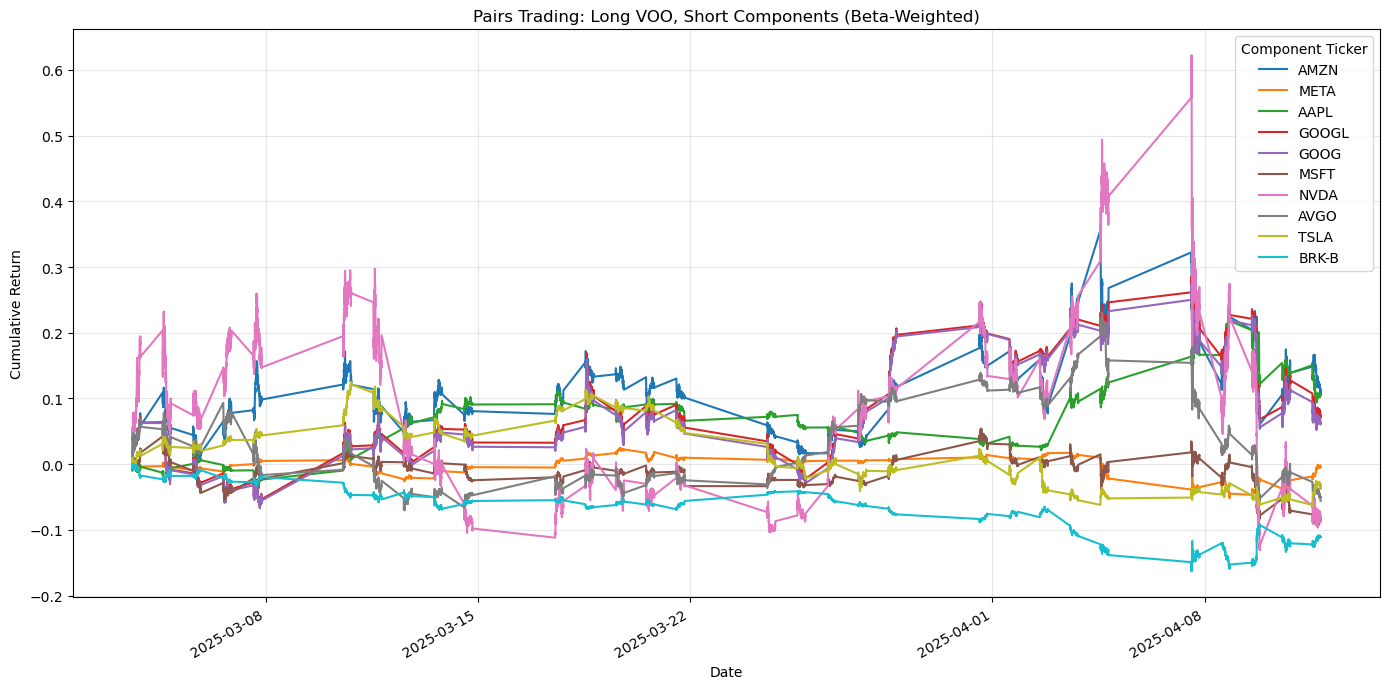

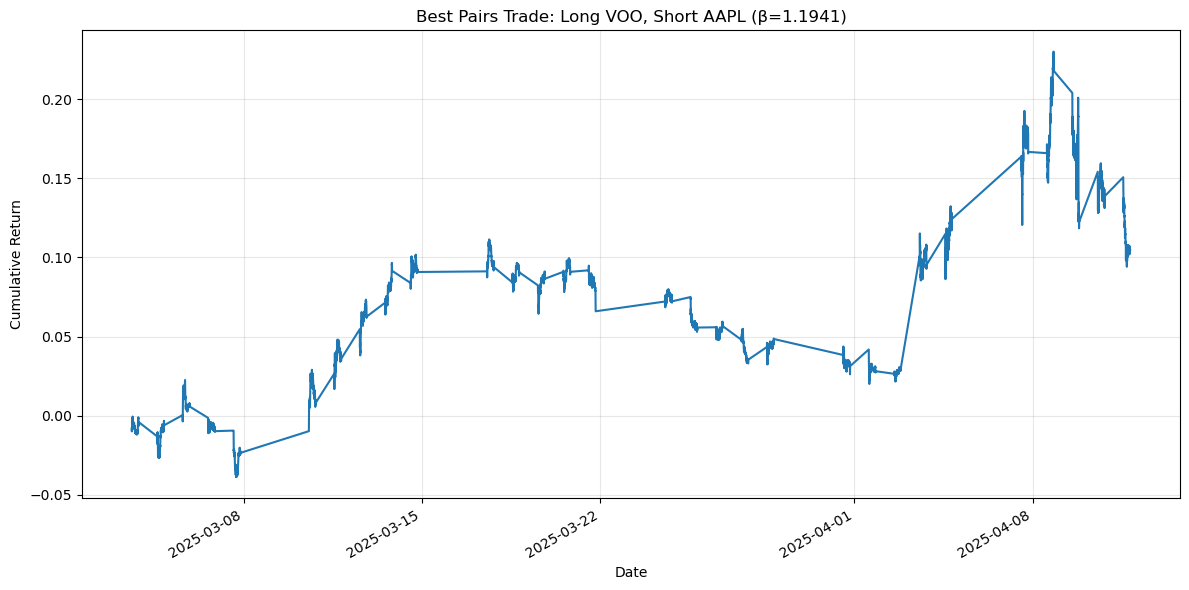

       Annualized Return  Annualized Vol  Sharpe Ratio  Max Drawdown  \
AAPL            1.031050        0.458333      2.249568     -9.545110   
AMZN            1.393313        0.930105      1.498016     -0.957021   
GOOGL           0.967889        0.789898      1.225334     -1.894703   
GOOG            0.862654        0.771807      1.117707     -1.949468   
NVDA            0.544461        1.673321      0.325378     -1.376388   
META           -0.024677        0.199433     -0.123734     -4.350737   
AVGO           -0.321450        0.653072     -0.492212     -1.752770   
TSLA           -0.274196        0.395967     -0.692472     -1.675347   
MSFT           -0.727262        0.451757     -1.609852     -2.699125   
BRK-B          -1.046621        0.293174     -3.569971   -678.636257   

       Final Return      Beta  
AAPL       0.104779  1.194147  
AMZN       0.109436  2.065672  
GOOGL      0.073194  2.428425  
GOOG       0.062724  2.422319  
NVDA      -0.087831  2.425277  
META      -0.00

In [30]:
performance_metrics, _, _ = build_etf_component_portfolio(ETF_ticker, df, regression_results)
print(performance_metrics)

# Train-Test split and backtest

In [32]:
def split_data(df, fraction):
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("DataFrame index must be a datetime type")
    
    df = df.copy()
    df['date'] = df.index.date
    
    unique_dates = df['date'].unique()
    num_train_days = int(len(unique_dates) * fraction)
    
    if num_train_days < 1:
        raise ValueError("Fraction too small, results in less than one day of training data")
    
    train_dates = unique_dates[:num_train_days]
    test_dates = unique_dates[num_train_days:]
    
    train_df = df[df['date'].isin(train_dates)]
    test_df = df[df['date'].isin(test_dates)]
    
    df.drop('date', axis=1, inplace=True)
    train_df = train_df.drop('date', axis=1)
    test_df = test_df.drop('date', axis=1)
    
    return train_df, test_df

In [35]:
train_df, test_df = split_data(df, 5/6)

In [37]:
test_df.head(5)

Ticker,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA,VOO
Datetime,,,,,,,,,,,
2025-04-07 13:30:00+00:00,177.600006,164.686798,142.250000,467.739990,144.759995,142.804993,488.619995,350.399994,88.885002,225.428802,449.190002
2025-04-07 13:32:00+00:00,177.625000,165.380005,141.410004,466.000000,143.869995,141.895004,488.739990,349.080811,88.409698,222.206696,448.160004
2025-04-07 13:34:00+00:00,177.169998,164.681000,141.490005,464.839996,143.474106,141.490005,487.079987,347.959991,87.949997,221.860001,447.059998
2025-04-07 13:36:00+00:00,177.320007,164.455002,141.240005,469.679993,143.289993,141.339996,487.517212,346.130005,87.809998,220.447495,446.450012
2025-04-07 13:38:00+00:00,177.910004,164.934998,140.399994,469.339996,143.634995,141.610107,485.350006,347.040009,88.639900,219.740005,446.644989


Margin from IB: https://www.interactivebrokers.com.hk/en/trading/margin-rates.php

In [40]:
def get_margin_rate(loan_amount, risk_free_rate=0.0433):
    if loan_amount <= 0:
        return 0
    elif loan_amount <= 100000:
        return max(0.0075, risk_free_rate + 0.015)
    elif loan_amount <= 1000000:
        return max(0.0075, risk_free_rate + 0.01)
    elif loan_amount <= 50000000:
        return max(0.0075, risk_free_rate + 0.0075)
    else:
        return max(0.0075, risk_free_rate + 0.005)

In [42]:
def construct_and_backtest_portfolio(etf_ticker, train_df, test_df, initial_capital=100000, transaction_fee_percent=0.001, risk_free_rate=0.0433, leverage_cap=1.5):
    regression_results = analyze_etf_components(etf_ticker, train_df)
    metrics, _, _ = build_etf_component_portfolio(etf_ticker, train_df, regression_results, plot_mode=False)
    
    positive_sharpe_components = metrics[metrics['Sharpe Ratio'] > 0]
    
    if positive_sharpe_components.empty:
        return pd.DataFrame(), 0, pd.DataFrame(), {}
    
    total_sharpe = positive_sharpe_components['Sharpe Ratio'].sum()
    portfolio_weights = positive_sharpe_components['Sharpe Ratio'] / total_sharpe
    
    # Calculate leverage for each component based on Sharpe ratio
    component_leverage = {}
    for component in positive_sharpe_components.index:
        sharpe = positive_sharpe_components.loc[component, 'Sharpe Ratio']
        if sharpe > 1:
            component_leverage[component] = min(sharpe, leverage_cap)
        else:
            component_leverage[component] = 1.0
    
    test_dates = pd.Series(test_df.index.date).unique()
    portfolio_value = pd.DataFrame(index=test_df.index)
    
    # Initialize columns with correct data types
    portfolio_value['Cash'] = float(initial_capital)
    portfolio_value['ETF Value'] = 0.0
    portfolio_value['Components Value'] = 0.0
    portfolio_value['Margin Used'] = 0.0
    portfolio_value['Margin Interest'] = 0.0
    portfolio_value['Total Value'] = float(initial_capital)
    portfolio_value['Positions'] = None
    
    current_positions = {}
    trade_log = []
    margin_loan = 0.0
    cumulative_margin_interest = 0.0
    
    # Starting cash
    cash_value = float(initial_capital)
    
    # Entry day - first trading day
    if len(test_dates) > 0:
        first_date = test_dates[0]
        first_day_df = test_df[test_df.index.date == first_date]
        first_15min = first_day_df.iloc[:15] if len(first_day_df) >= 15 else first_day_df
        
        if len(first_15min) > 0:
            # Open positions for each component
            for component, weight in portfolio_weights.items():
                if component not in first_15min.columns:
                    continue
                
                beta = metrics.loc[component, 'Beta']
                if beta <= 0:
                    continue
                
                component_allocation = initial_capital * weight
                leverage = component_leverage[component]
                
                # Apply leverage to allocation
                leveraged_allocation = component_allocation * leverage
                
                # Sample entry time randomly from first 15 minutes
                entry_time = first_15min.sample(1).index[0]
                
                # Get entry prices 
                etf_price = float(first_15min.loc[entry_time, etf_ticker])
                component_price = float(first_15min.loc[entry_time, component])
                
                # Calculate shares to trade with leverage
                etf_notional = leveraged_allocation / 2
                component_notional = leveraged_allocation / 2
                
                etf_shares = etf_notional / etf_price
                component_shares = component_notional / component_price
                
                # Calculate costs and fees
                etf_cost = etf_shares * etf_price
                component_cost = component_shares * component_price
                
                etf_fee = etf_cost * transaction_fee_percent
                component_fee = component_cost * transaction_fee_percent
                
                # Update cash: add for shorting ETF, subtract for buying component
                cash_value += etf_cost - component_cost - etf_fee - component_fee
                
                # Add to margin loan for leveraged positions
                margin_used = 0.0
                if leverage > 1:
                    margin_used = etf_cost * (leverage - 1) / leverage
                    margin_loan += margin_used
                
                # Store position details
                current_positions[component] = {
                    'ETF Shares': -etf_shares,  # Negative for short
                    'Component Shares': component_shares,  # Positive for long
                    'ETF Entry Price': etf_price,
                    'Component Entry Price': component_price,
                    'Entry Time': entry_time,
                    'Leverage': leverage,
                    'Margin Used': margin_used
                }
                
                # Log the trade
                trade_log.append({
                    'Date': entry_time,
                    'Action': 'ENTRY',
                    'Ticker': f"{etf_ticker}/{component}",
                    'ETF Price': etf_price,
                    'Component Price': component_price,
                    'ETF Shares': -etf_shares,  # Negative for short
                    'Component Shares': component_shares,  # Positive for long
                    'ETF Value': -etf_cost,  # Negative for short
                    'Component Value': component_cost,  # Positive for long
                    'Leverage': leverage,
                    'Fees': etf_fee + component_fee
                })
    
    # Previous day interest
    prev_day_interest = 0.0
    
    # Loop through all time points to update portfolio values
    for current_date in test_dates:
        day_df = test_df[test_df.index.date == current_date]
        
        # Calculate daily margin interest for this day
        if margin_loan > 0:
            margin_rate = get_margin_rate(margin_loan, risk_free_rate)
            daily_interest = margin_loan * margin_rate / 365
            day_interest = daily_interest
        else:
            day_interest = 0.0
            
        # Track if we need to exit on this day
        exit_day = (current_date == test_dates[-1])
        exit_time = None
        
        # Track positions closed
        positions_closed = False
            
        # Process each time point in the day
        for idx in day_df.index:
            if positions_closed:
                continue
                
            # For the last day, check if we need to exit
            if exit_day and idx == day_df.index[-1]:
                exit_time = idx
                # Close all positions
                for component, pos in list(current_positions.items()):
                    if component in test_df.columns:
                        # Get exit prices
                        exit_etf_price = float(test_df.loc[idx, etf_ticker])
                        exit_component_price = float(test_df.loc[idx, component])
                        
                        # Calculate price difference profit
                        etf_price_diff = pos['ETF Entry Price'] - exit_etf_price  # For short: entry - exit
                        component_price_diff = exit_component_price - pos['Component Entry Price']  # For long: exit - entry
                        
                        etf_profit = etf_price_diff * (-pos['ETF Shares'])  # Negative shares for short
                        component_profit = component_price_diff * pos['Component Shares']
                        
                        profit = etf_profit + component_profit
                        
                        # Calculate values to close positions
                        etf_exit_value = pos['ETF Shares'] * exit_etf_price  # Will be negative for short
                        component_exit_value = pos['Component Shares'] * exit_component_price  # Will be positive for long
                        
                        # To close: buy back the ETF (subtract from cash) and sell the component (add to cash)
                        etf_close_cost = -etf_exit_value  # Buying back costs money
                        component_close_value = component_exit_value  # Selling adds money
                        
                        # Calculate fees
                        etf_fee = abs(etf_close_cost) * transaction_fee_percent
                        component_fee = abs(component_close_value) * transaction_fee_percent
                        
                        # Update cash
                        cash_value += -etf_close_cost + component_close_value - etf_fee - component_fee
                        
                        # Reduce margin loan for leveraged positions
                        if pos['Leverage'] > 1:
                            margin_loan -= abs(pos['Margin Used'])
                            margin_loan = max(0.0, margin_loan)  # Ensure no negative margin
                        
                        # Log the exit trade
                        trade_log.append({
                            'Date': idx,
                            'Action': 'EXIT',
                            'Ticker': f"{etf_ticker}/{component}",
                            'ETF Price': exit_etf_price,
                            'Component Price': exit_component_price,
                            'ETF Shares': -pos['ETF Shares'],  # Positive to buy back what we shorted
                            'Component Shares': -pos['Component Shares'],  # Negative to sell what we bought
                            'ETF Value': etf_close_cost,  # Positive cost to buy back
                            'Component Value': component_close_value,  # Positive value from selling
                            'Leverage': pos['Leverage'],
                            'Fees': etf_fee + component_fee,
                            'Profit': profit
                        })
                
                # Clear positions
                current_positions = {}
                positions_closed = True
            
            # Calculate current position values
            etf_value = 0.0
            components_value = 0.0
            positions_info = []
            
            for component, pos in current_positions.items():
                if component in test_df.columns and etf_ticker in test_df.columns:
                    try:
                        # Get current prices
                        current_etf_price = float(test_df.loc[idx, etf_ticker])
                        current_component_price = float(test_df.loc[idx, component])
                        
                        # Calculate position values using mark-to-market
                        current_etf_value = pos['ETF Shares'] * current_etf_price  # Negative for short
                        current_component_value = pos['Component Shares'] * current_component_price  # Positive for long
                        
                        # Add to total values
                        etf_value += current_etf_value
                        components_value += current_component_value
                        
                        # Add position info for display
                        positions_info.append(f"{etf_ticker}:{pos['ETF Shares']:.0f}@{pos['ETF Entry Price']:.2f}, "
                                            f"{component}:{pos['Component Shares']:.0f}@{pos['Component Entry Price']:.2f}")
                    except Exception as e:
                        print(f"Error calculating position values: {str(e)}")
            
            # Time fraction for interest (divide daily interest by number of time points in the day)
            time_fraction = 1.0 / len(day_df)
            period_interest = day_interest * time_fraction
            cumulative_margin_interest += period_interest
            
            # Update portfolio value dataframe for this time point
            portfolio_value.loc[idx, 'ETF Value'] = etf_value
            portfolio_value.loc[idx, 'Components Value'] = components_value
            portfolio_value.loc[idx, 'Margin Used'] = margin_loan
            portfolio_value.loc[idx, 'Margin Interest'] = cumulative_margin_interest
            portfolio_value.loc[idx, 'Cash'] = cash_value - cumulative_margin_interest
            portfolio_value.loc[idx, 'Total Value'] = cash_value + etf_value + components_value - cumulative_margin_interest
            portfolio_value.loc[idx, 'Positions'] = '; '.join(positions_info) if positions_info else None
    
    # Create trade log dataframe  
    trade_log_df = pd.DataFrame(trade_log)
    
    # Calculate final return
    final_return = (portfolio_value['Total Value'].iloc[-1] / initial_capital) - 1
    
    # Portfolio stats
    portfolio_stats = {
        'Initial Capital': initial_capital,
        'Final Value': portfolio_value['Total Value'].iloc[-1],
        'Total Return': final_return,
        'Total Margin Interest': cumulative_margin_interest,
        'Component Weights': portfolio_weights.to_dict(),
        'Sharpe Ratios': positive_sharpe_components['Sharpe Ratio'].to_dict(),
        'Betas': positive_sharpe_components['Beta'].to_dict(),
        'Component Leverage': component_leverage
    }
    
    return portfolio_value, final_return, trade_log_df, portfolio_stats

In [44]:
portfolio_value, final_return, trade_log_df, portfolio_stats = construct_and_backtest_portfolio(ETF_ticker, 
                                                            train_df, test_df, initial_capital=10000, 
                                                            transaction_fee_percent=0.001,
                                                            risk_free_rate=0.0433,
                                                            leverage_cap=1.5)

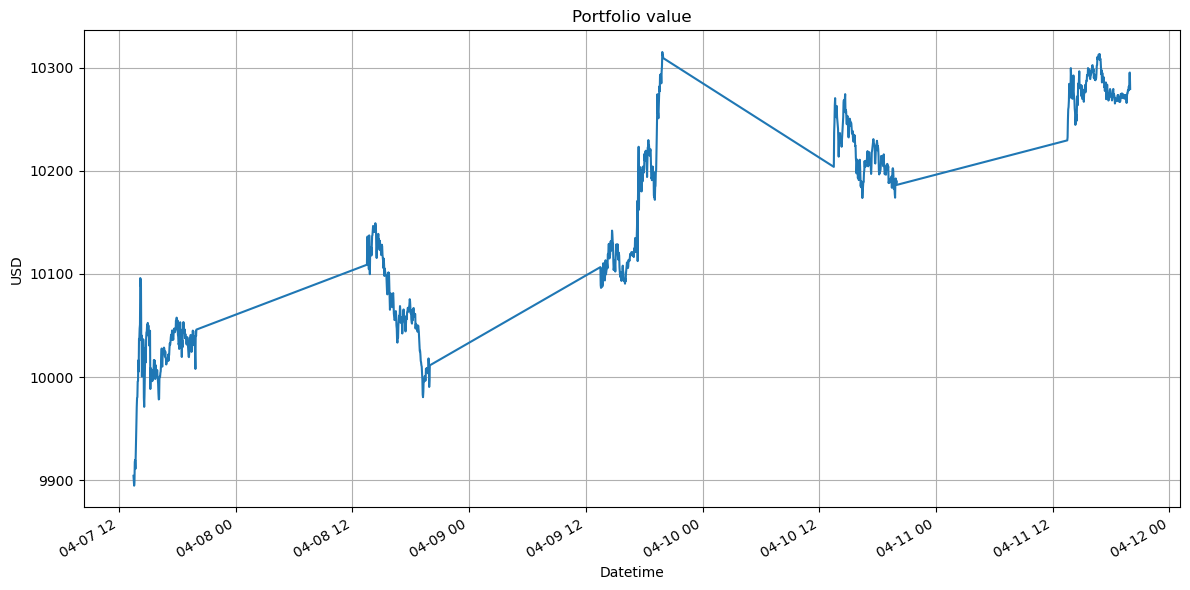

In [46]:
portfolio_value['Total Value'].plot(figsize=(12,6),title='Portfolio value')
plt.ylabel('USD')
plt.grid(True)
plt.tight_layout()
plt.show()

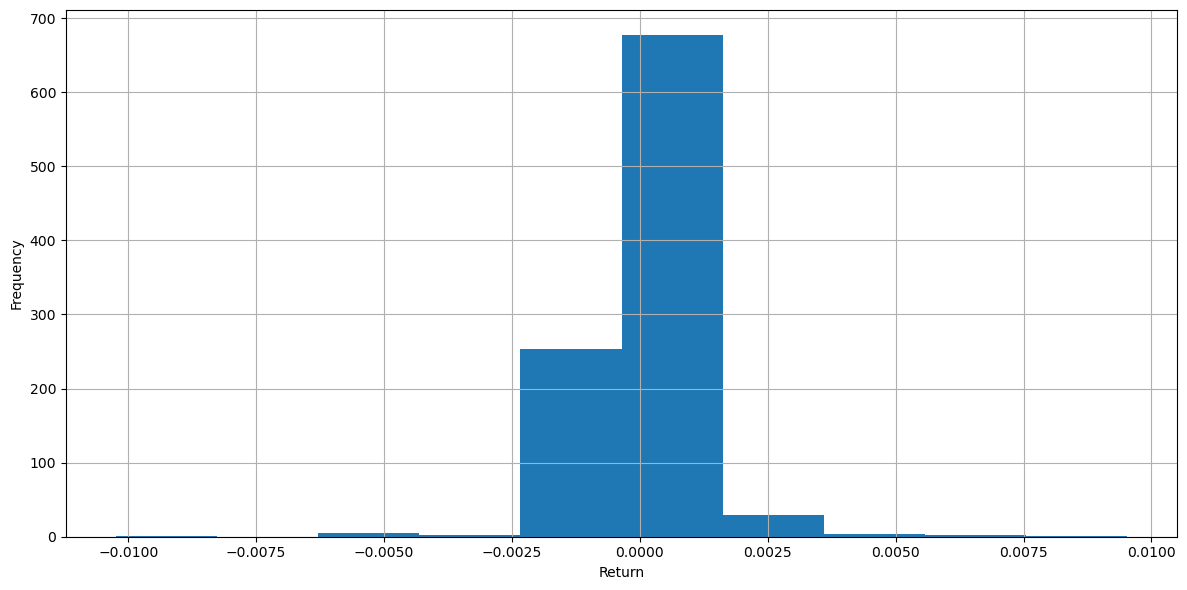

In [48]:
portfolio_value['Total Value'].pct_change().plot.hist(figsize=(12,6))
plt.xlabel('Return')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
portfolio_stats

{'Initial Capital': 10000,
 'Final Value': 10279.54385668303,
 'Total Return': 0.027954385668303106,
 'Total Margin Interest': 1.9532737985487107,
 'Component Weights': {'AMZN': 0.19711263299433338,
  'GOOGL': 0.18692611571406448,
  'NVDA': 0.18149693763540733,
  'GOOG': 0.17717745996180168,
  'AAPL': 0.17409915176610305,
  'AVGO': 0.08318770192829011},
 'Sharpe Ratios': {'AMZN': 3.245362896113409,
  'GOOGL': 3.0776468815698195,
  'NVDA': 2.9882581253789735,
  'GOOG': 2.9171400424861686,
  'AAPL': 2.866457206742153,
  'AVGO': 1.369644741434588},
 'Betas': {'AMZN': 1.6324880869747247,
  'GOOGL': 1.7034443812520954,
  'NVDA': 1.5923171712762003,
  'GOOG': 1.6890679386253948,
  'AAPL': 1.0092179797288847,
  'AVGO': 0.6868425277507496},
 'Component Leverage': {'AMZN': 1.5,
  'GOOGL': 1.5,
  'NVDA': 1.5,
  'GOOG': 1.5,
  'AAPL': 1.5,
  'AVGO': 1.369644741434588}}